# Set up

## Paths

In [51]:
DIR_MAIN = '..'

In [56]:
%%bash -s "$DIR_MAIN"
DIR_MAIN=$1

ls $DIR_MAIN

code
data
material
notes
tools


## Tools

A list of tools: PLINK2.

In [4]:
PLINK = f'{DIR_MAIN}/tools/plink2'

In [42]:
%%bash -s "$PLINK"
PLINK=$1

$PLINK --version

PLINK v2.00a3.7 64-bit (24 Oct 2022)


In [65]:
REGENIE='/usr/local/Caskroom/miniconda/base/envs/regenie/bin/regenie'

In [67]:
%%bash -s "$REGENIE"
REGENIE=$1

$REGENIE --version

v3.2.6.gz


## Datasets

In [35]:
DIR_DATA = f'{DIR_MAIN}/data/'
D1_PHENO = f'{DIR_DATA}/sim_rels_pheno.txt'
D1_BFILE = f'{DIR_DATA}/sim_rels_geno'

## R enviroment

In [8]:
%%bash
R --version

R version 4.2.2 (2022-10-31) -- "Innocent and Trusting"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: x86_64-apple-darwin21.6.0 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
https://www.gnu.org/licenses/.



In [9]:
 import rpy2.ipython

In [10]:
%%capture
%load_ext rpy2.ipython

In [19]:
%%R
 print('Hello World from R!')

[1] "Hello World from R!"


In [57]:
%%R
library(tidyverse)
library(data.table)

In [60]:
%%R
library(qqman)

## Datasets

# GWAS on simulated dataset 1

## Exploratory data analysis before GWAS

1. What is the sample size? 
2. What is the ditribution of phenotype? 
    - Is it binary or quantitative? 
    - If it is quantitative, does the distribution look normal?

In [47]:
%%R -i D1_PHENO
phen = fread(D1_PHENO) %>% as_tibble
str(phen)

tibble [2,400 × 3] (S3: tbl_df/tbl/data.frame)
 $ FID  : int [1:2400] 2307 379 478 1545 990 1907 369 1694 2137 2314 ...
 $ IID  : int [1:2400] 2307 379 478 1545 990 1907 369 1694 2137 2314 ...
 $ Pheno: num [1:2400] 0.00999 -1.45253 0.11097 1.11363 -0.20993 ...
 - attr(*, ".internal.selfref")=<externalptr> 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


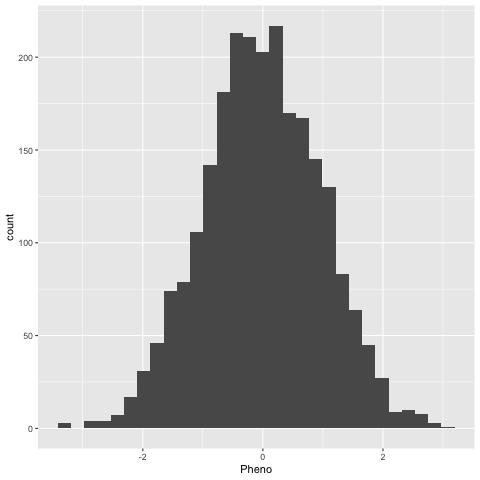

In [26]:
%%R
ggplot(phen, aes(Pheno)) + geom_histogram()

## Run GWAS using Plink

In [49]:
%%bash -s "$PLINK" "$D1_BFILE" "$D1_PHENO"
PLINK=$1
D1_BFILE=$2
D1_PHENO=$3

cmd="$PLINK --bfile $D1_BFILE 
    --pheno $D1_PHENO --pheno-name Pheno 
    --maf 0.01 --geno 0.1 --hwe 1e-10 
    --glm allow-no-covars --out gwas_plink"
eval $cmd


PLINK v2.00a3.7 64-bit (24 Oct 2022)           www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to gwas_plink.log.
Options in effect:
  --bfile ../data//sim_rels_geno
  --geno 0.1
  --glm allow-no-covars
  --hwe 1e-10
  --maf 0.01
  --out gwas_plink
  --pheno ../data//sim_rels_pheno.txt
  --pheno-name Pheno

Start time: Fri Apr 21 15:41:13 2023
16384 MiB RAM detected; reserving 8192 MiB for main workspace.
Using up to 12 threads (change this with --threads).
2400 samples (1179 females, 1221 males; 2400 founders) loaded from
../data//sim_rels_geno.fam.
106134 variants loaded from ../data//sim_rels_geno.bim.
1 quantitative phenotype loaded (2400 values).
Calculating allele frequencies... 0%61%done.
--geno: 0 variants removed due to missing genotype data.
--hwe: 0 variants removed due to Hardy-Weinberg exact test (founders only).
125 variants removed due to allele frequency threshold(s)
(--maf/--max-maf/--mac/--max

Check the output file.

In [50]:
%%bash 
head gwas_plink.Pheno.glm.linear | cut -f 3,9-12 | column -t

ID              BETA         SE         T_STAT     P
1:12000011:A:C  0.0122331    0.0437981  0.279307   0.780034
1:12000012:A:C  -0.0179816   0.0361811  -0.496988  0.619243
1:12000019:T:C  -0.0848826   0.028367   -2.99231   0.00279703
1:12000027:C:T  0.0125431    0.0434929  0.288394   0.77307
1:12000036:G:A  0.0111345    0.0287975  0.386647   0.699052
1:12000061:C:T  -0.00781173  0.0305395  -0.255791  0.798134
1:12000073:C:T  -0.12345     0.0571993  -2.15825   0.0310072
1:12000074:A:C  -0.0319143   0.0302438  -1.05523   0.291425
1:12000117:G:A  0.00668323   0.0282828  0.2363     0.81322


Read the association results into R for further analysis.

In [61]:
%%R
assoc = fread('gwas_plink.Pheno.glm.linear') %>% as_tibble
str(assoc)

tibble [106,009 × 13] (S3: tbl_df/tbl/data.frame)
 $ #CHROM : int [1:106009] 1 1 1 1 1 1 1 1 1 1 ...
 $ POS    : int [1:106009] 12000011 12000012 12000019 12000027 12000036 12000061 12000073 12000074 12000117 12000136 ...
 $ ID     : chr [1:106009] "1:12000011:A:C" "1:12000012:A:C" "1:12000019:T:C" "1:12000027:C:T" ...
 $ REF    : chr [1:106009] "C" "C" "C" "T" ...
 $ ALT    : chr [1:106009] "A" "A" "T" "C" ...
 $ A1     : chr [1:106009] "A" "A" "T" "C" ...
 $ TEST   : chr [1:106009] "ADD" "ADD" "ADD" "ADD" ...
 $ OBS_CT : int [1:106009] 2400 2400 2400 2400 2400 2400 2400 2400 2400 2400 ...
 $ BETA   : num [1:106009] 0.0122 -0.018 -0.0849 0.0125 0.0111 ...
 $ SE     : num [1:106009] 0.0438 0.0362 0.0284 0.0435 0.0288 ...
 $ T_STAT : num [1:106009] 0.279 -0.497 -2.992 0.288 0.387 ...
 $ P      : num [1:106009] 0.78 0.6192 0.0028 0.7731 0.6991 ...
 $ ERRCODE: chr [1:106009] "." "." "." "." ...
 - attr(*, ".internal.selfref")=<externalptr> 


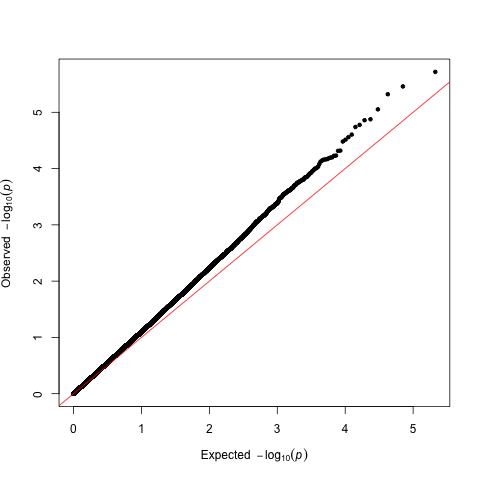

In [62]:
%%R
# qq plot by qqman
qq(assoc$P)

In [64]:
%%R
median(qchisq(assoc$P, df = 1, lower.tail = FALSE)) / qchisq(0.5, df = 1, lower.tail = FALSE)

[1] 1.148994
